In [ ]:
from db_connection import DB_Connection
import pandas as pd, numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import TextBox
import re, json
from wordcloud import WordCloud
import Tweet


db = DB_Connection()

database = db.query('''SELECT * FROM TWTTWEET WHERE TWEET_CREATED<'2021-01-01'
                    ORDER BY TWEET_CREATED DESC;''')
df = pd.DataFrame(database, columns=['id','userid','text','date',
                            'link','media1','media2','media3', 'media4'])
df = df.loc[:, ['id', 'text']]


processed = Tweet.clean_text(df, 'text')
classified = Tweet.classify_text(processed, 'clean')

# incidents = classified[['id','isIncident']].groupby('isIncident').size()
# accidents = classified[['id','isAccident']].groupby('isAccident').size()[1]
# dangers = classified[['id','isDanger']].groupby('isDanger').size()[1]
# obstacles = classified[['id','isObstacle']].groupby('isObstacle').size()[1]

In [ ]:
x = [0,1,2]
data = [accidents,obstacles,dangers]
plt.figure(figsize=(10,6))
g = sns.barplot(x=x, y=data)
plt.title('% de incidentes por categoría', fontsize=16)
plt.xticks(ticks=x,
        labels=['accidentes','obstáculos','peligros'],
        fontsize=13)
plt.ylim(top=65000)

for i, v in enumerate(data):
    g.text(i, v+1000, v, color='black', ha="center", fontsize=12)
    # plt.annotate(v, (i+3, 10), color='black', fontsize=12)
plt.show()

## Text classification

In [ ]:
from sklearn.svm import LinearSVC
import pickle
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
classified.head(1)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=600, min_df=5, max_df=0.7)
X1 = vectorizer.fit_transform(classified.clean).toarray()

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X2 = tfidf.fit_transform(X1)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfi = TfidfVectorizer(sublinear_tf=True, max_features=500, min_df=5, max_df=0.7, encoding='utf-8', ngram_range=(1,2))
X3 = tfi.fit_transform(classified.clean).toarray()
# labels = classified.isIncident

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, classified.isIncident, test_size=0.2, random_state=0)

### Random Forest

In [ ]:
start = time.time()
ranfor = RandomForestClassifier(n_estimators=512, random_state=0)
ranfor.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_pred = ranfor.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

In [ ]:
rf_con = confusion_matrix(y_test,y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                rf_con.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     rf_con.flatten()/np.sum(rf_con)]
labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,4))
sns.heatmap(rf_con/np.sum(rf_con), annot=labels, fmt='', cmap='Blues')
plt.title('Matriz de confusión para Random Forest', fontsize=14)
plt.show()

In [ ]:
with open('ranfor_classifier', 'wb') as picklefile:
    pickle.dump(ranfor, picklefile)

In [ ]:
# load model
with open('ranfor_classifier', 'rb') as training_model:
    ranfor = pickle.load(training_model)

In [ ]:
resume = []
for i in [16,32,64]:#,128,256,512,1024,2048,4096,8192]:
    print('\nPrediction with:', str(i))
    start = time.time()
    ranfor = RandomForestClassifier(n_estimators=i, random_state=0)
    ranfor.fit(X_train, y_train)
    end = time.time()
    y_pred = ranfor.predict(X_test)
    print(str(end-start), accuracy_score(y_test, y_pred))
    resume.append([i, end-start, accuracy_score(y_test, y_pred),
        confusion_matrix(y_test,y_pred), classification_report(y_test,y_pred)])

In [ ]:
for i in [128,256,512,1024,2048,4096,8192]:
    print('\nPrediction with:', str(i))
    start = time.time()
    ranfor = RandomForestClassifier(n_estimators=i, random_state=0)
    ranfor.fit(X_train, y_train)
    end = time.time()
    y_pred = ranfor.predict(X_test)
    print(str(end-start), accuracy_score(y_test, y_pred))
    resume.append([i, end-start, accuracy_score(y_test, y_pred),
        confusion_matrix(y_test,y_pred), classification_report(y_test,y_pred)])

In [ ]:
xs = [i[0] for i in resume]
ys = [i[1] for i in resume]
zs = [i[2] for i in resume]

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
# sns.lineplot(x=range(len(xs)), y=ys, markers=True, style='event')
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.show()

### Boosting Model

In [ ]:
from xgboost import XGBClassifier

start = time.time()
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_xgb = xgb.predict(X_test)

print(confusion_matrix(y_test,y_xgb))
print(classification_report(y_test,y_xgb))
print(accuracy_score(y_test, y_xgb))

In [ ]:
xgresume = []

for i in [64,128,256,512,1024,2048,4096]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(n_estimators=i, learning_rate=0.3, eval_metric='error') # learning_rate
    xgb.fit(X_train, y_train)
    end = time.time()
    y_xgb = xgb.predict(X_test)
    print(str(end-start), accuracy_score(y_test, y_xgb))
    xgresume.append([i, end-start, accuracy_score(y_test, y_xgb),
    confusion_matrix(y_test,y_xgb), classification_report(y_test,y_xgb)])

In [ ]:
xs = [i[0] for i in xgresume]
ys = [i[2] for i in xgresume]
zs = [i[3] for i in xgresume]

plt.figure(figsize=(11,4))
plt.title('XGBoost')
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
# sns.lineplot(x=range(len(xs)), y=ys, markers=True, style='event')
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn import metrics
import xgboost as xgb
import time

In [ ]:
param_test0 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

start = time.time()
gsearch0 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=6,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test0, scoring='accuracy',n_jobs=4, cv=3, verbose=2)
gsearch0.fit(X_train, y_train)
end = time.time()
print(str(end-start))
gsearch0.best_params_, gsearch0.best_score_

In [ ]:
param_test1 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=9,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='accuracy',n_jobs=4, cv=3, verbose=3)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test2 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=9,
                                        min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test2, scoring='accuracy',n_jobs=4, cv=3, verbose=3)
gsearch2.fit(X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_

In [ ]:
param_test3 = {
 'reg_alpha':[0, 1e-5, 0.001, 0.005, 0.01, 0.05, 0.1]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=9,
                                        min_child_weight=1, gamma=0.1, subsample=0.9, colsample_bytree=0.9,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test3, scoring='accuracy',n_jobs=4, cv=3, verbose=3)
gsearch3.fit(X_train, y_train)
gsearch3.best_params_, gsearch3.best_score_

In [ ]:
grid_results3 = pd.DataFrame(gsearch3.cv_results_)
grid_results3.sort_values('rank_test_score').head(5)#[['rank_test_score','param_colsample_bytree', 'param_subsample', 'mean_test_score', 'std_test_score']].rename(columns={'param_colsample_bytree':'colsample_bytree', 'param_param_subsample':'subsample'})

In [ ]:
grid_results3.to_csv('grid_search_results3.csv')

In [ ]:
xgb1 = XGBClassifier(
    learning_rate=0.3,
    n_estimators=2000,
    max_depth=9, min_child_weight=1,
    gamma=0.1, subsample=0.9, colsample_bytree=0.9,
    nthread=4, seed=27, verbosity=3)

xgb_param = xgb1.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=5,
    early_stopping_rounds=50)
xgb1.set_params(n_estimators=cvresult.shape[0])

In [ ]:
#Fit the algorithm on the data
print('Start training.')
start = time.time()
xgb1.fit(X_train, y_train, verbose=True)
print('End training.') 
end = time.time()
    
#Predict training set:
dtrain_predictions = xgb1.predict(X_test)
dtrain_predprob = xgb1.predict_proba(X_test)[:,1]
    
#Print model report:
print("\nModel Report")
print("Duration:", str(end-start))
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtrain_predictions))
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob))
                
plt.figure(figsize=(15,5))
feat_imp = pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
xgresume = []
xgb_arr = []

for i in [64,128,256,512,1024,2048,4096]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(
        learning_rate=0.3,
        n_estimators=i,
        max_depth=9, min_child_weight=1,
        gamma=0.1, subsample=0.9, colsample_bytree=0.9,
        nthread=4, seed=27, eval_metric='error', verbosity=0)
    xgb_arr.append(xgb)
    xgb_arr[-1].fit(X_train, y_train)
    end = time.time()
    y_xgb = xgb_arr[-1].predict(X_test)
    print(str(end-start), accuracy_score(y_test, y_xgb))
    xgresume.append([i, end-start, accuracy_score(y_test, y_xgb),
    confusion_matrix(y_test,y_xgb), classification_report(y_test,y_xgb)])

In [40]:
for i in xgresume:
    for s in i: print(s)
    print('\n')

64
66.17066931724548
0.9767740096893702
[[13279    93]
 [  722 20996]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13372
           1       1.00      0.97      0.98     21718

    accuracy                           0.98     35090
   macro avg       0.97      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090



128
138.33670783042908
0.9771159874608151
[[13250   122]
 [  681 21037]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13372
           1       0.99      0.97      0.98     21718

    accuracy                           0.98     35090
   macro avg       0.97      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090



256
351.80944895744324
0.9779709318894272
[[13236   136]
 [  637 21081]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13372
           1    

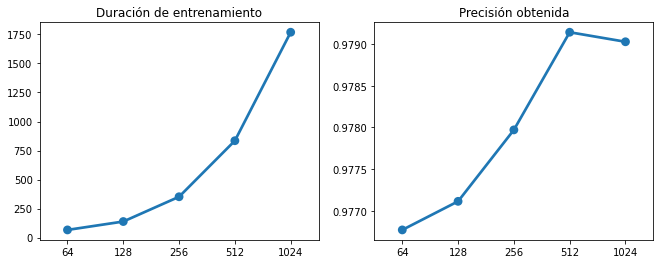

In [21]:
xs = [i[0] for i in xgresume]
ys = [i[1] for i in xgresume]
zs = [i[2] for i in xgresume]

plt.figure(figsize=(11,4))
plt.title('XGBoost')
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.show()

In [23]:
xgresume1 = []
xgb_arr1 = []

for i in [400,500,600,700,800,900]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(
        learning_rate=0.3,
        n_estimators=i,
        max_depth=9, min_child_weight=1,
        gamma=0.1, subsample=0.9, colsample_bytree=0.9,
        nthread=4, seed=27, eval_metric='error', verbosity=0)
    xgb_arr1.append(xgb)
    xgb_arr1[-1].fit(X_train, y_train)
    end = time.time()
    y_xgb = xgb_arr1[-1].predict(X_test)
    print(str(end-start), accuracy_score(y_test, y_xgb))
    xgresume1.append([i, end-start, accuracy_score(y_test, y_xgb),
    confusion_matrix(y_test,y_xgb), classification_report(y_test,y_xgb)])


estimators: 400
1078.2287690639496 0.9787403818751781

estimators: 500
1369.554790019989 0.9791963522371046

estimators: 600
1245.779415845871 0.9789683670561413

estimators: 700
1072.435142993927 0.9791108577942433

estimators: 800
1305.388735294342 0.9789683670561413

estimators: 900
1466.4413249492645 0.9791678540894841


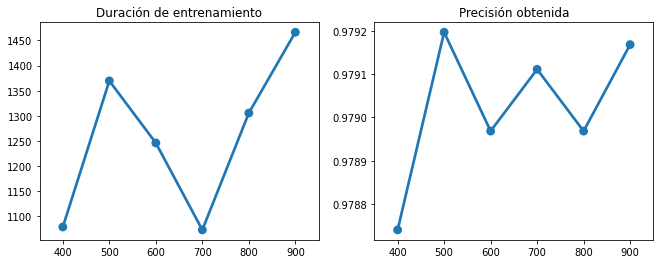

In [26]:
xs = [i[0] for i in xgresume1]
ys = [i[1] for i in xgresume1]
zs = [i[2] for i in xgresume1]

plt.figure(figsize=(11,4))
plt.title('XGBoost')
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.show()

In [43]:
xgb_final = xgb_arr1[1]
y_xgb = xgb_final.predict(X_test)

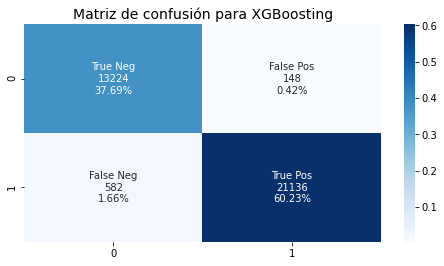

In [44]:
xgb_con = confusion_matrix(y_test,y_xgb)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                xgb_con.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     xgb_con.flatten()/np.sum(xgb_con)]
labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,4))
sns.heatmap(xgb_con/np.sum(xgb_con), annot=labels, fmt='', cmap='Blues')
plt.title('Matriz de confusión para XGBoosting', fontsize=14)
plt.show()

In [32]:
with open('xgb_classifier', 'wb') as picklefile:
    pickle.dump(xgb_final, picklefile)

### SVM

In [ ]:
start = time.time()
svc = LinearSVC()
svc.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_svc = svc.predict(X_test)

print(confusion_matrix(y_test,y_svc))
print(classification_report(y_test,y_svc))
print(accuracy_score(y_test, y_svc))

In [ ]:
with open('svc_classifier', 'wb') as picklefile:
    pickle.dump(svc, picklefile)

In [ ]:
# load model
with open('ranfor_classifier', 'rb') as training_model:
    ranfor = pickle.load(training_model)

### Naive-Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

start = time.time()
nb = MultinomialNB()
nb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_nb = nb.predict(X_test)

print(confusion_matrix(y_test,y_nb))
print(classification_report(y_test,y_nb))
print(accuracy_score(y_test, y_nb))

### Gaussian Naive-Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

start = time.time()
gnb = GaussianNB()
gnb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_gnb = gnb.predict(X_test)

print(confusion_matrix(y_test,y_gnb))
print(classification_report(y_test,y_gnb))
print(accuracy_score(y_test, y_gnb))

### Boosting RF Model

In [ ]:
from xgboost import XGBRFClassifier

start = time.time()
xrfgb = XGBRFClassifier()
xrfgb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_xrfgb = xrfgb.predict(X_test)

print(confusion_matrix(y_test,y_xrfgb))
print(classification_report(y_test,y_xrfgb))
print(accuracy_score(y_test, y_xrfgb))